## Load & Calculate Perceptual Hash Value for each image in the dataset

In [4]:
# Importing necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind, ranksums
import imagehash
from PIL import Image
import numpy as np
from IPython.display import display


## Load Dataset & Saving output to CSV File

In [6]:
# Define the image folder and output file path
image_folder = 'D:\GitProjects\Datasets\ImageData\consolidated'
output_file = 'image_hashes.csv'

# Define a function to resize images
def resize_image(image, size=(128, 128)):
    return image.resize(size)

# Define a function to extract statistical features from images
def extract_statistical_features(image):
    image_array = np.array(image.convert('L')).flatten()  # Convert to grayscale and flatten
    mean = np.mean(image_array)
    std = np.std(image_array)
    skewness = pd.Series(image_array).skew()
    kurtosis = pd.Series(image_array).kurtosis()
    return [mean, std, skewness, kurtosis]

# Process images and create a DataFrame
data = []
for subdir, dirs, files in os.walk(image_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(subdir, file)
            try:
                image = Image.open(image_path)
                image_resized = resize_image(image)
                hash_value = imagehash.phash(image_resized)
                class_label = os.path.basename(subdir)  # Use folder name as class label
                stats = extract_statistical_features(image_resized)
                data.append((file, str(hash_value), class_label, *stats))
            except Exception as e:
                print(f'Error processing {file}: {e}')

# Convert the data into a DataFrame
columns = ['filename', 'hash', 'label', 'mean', 'std', 'skewness', 'kurtosis']
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame with image hashes to a CSV file
df.to_csv(output_file, index=False)
print(f'Saved image hashes to {output_file}')

# Display the first few rows of the DataFrame
df.head()


Saved image hashes to image_hashes.csv


,filename,hash,label,mean,std,skewness,kurtosis
0,0001.jpg,c06b2ff8b19086cf,autistic,139.447754,61.240496,-0.195112,-1.059572
1,0002.jpg,c03f6bb43990f4c3,autistic,127.053101,54.445597,-0.065493,-1.000039
2,0003.jpg,8d283c7d3394d4f4,autistic,147.401001,61.984623,-0.715674,-0.780351
3,0004.jpg,c02f2bb4ecd3c24b,autistic,135.558899,63.491497,-0.019400,-1.210997
4,0005.jpg,bf026c37633ae898,autistic,128.695129,66.594278,-0.037159,-0.853016


## Exploratory Data Analysis (EDA)

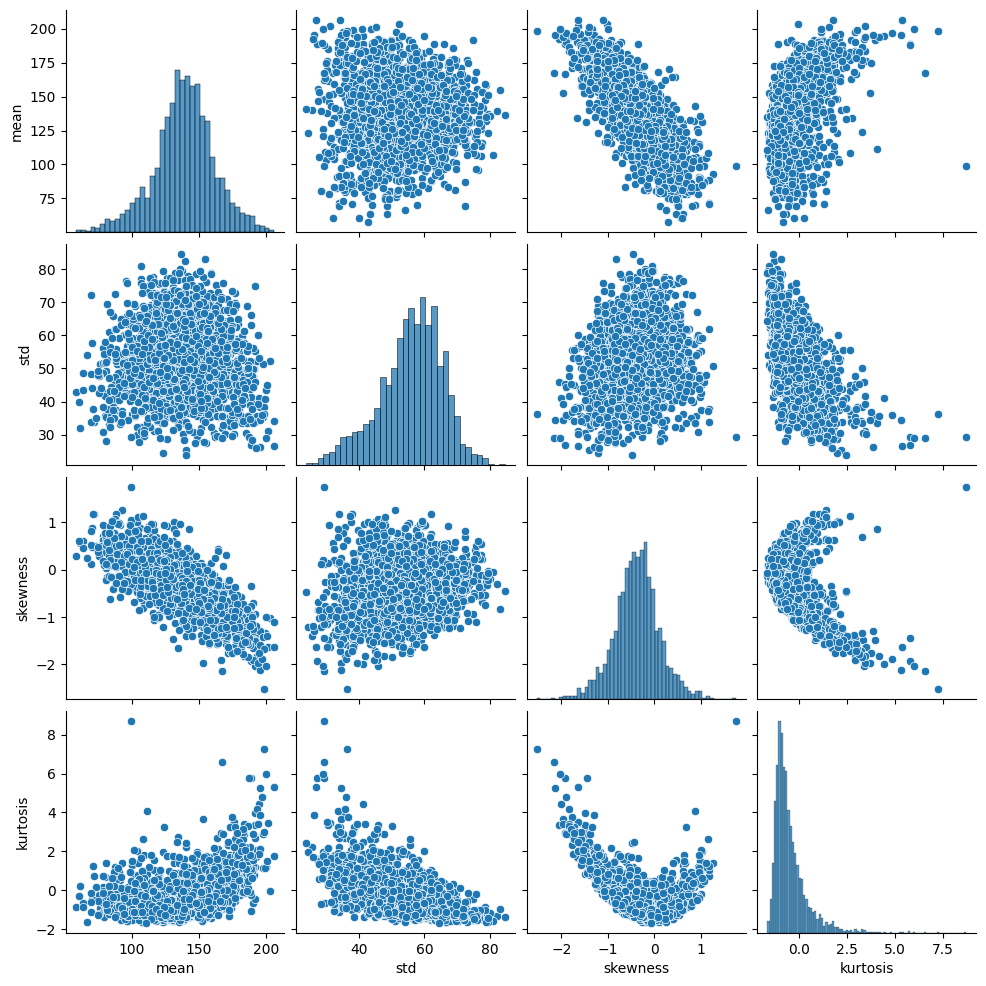

In [7]:
# Perform EDA by plotting pairplots of the numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

if len(numeric_columns) > 0:
    sns.pairplot(df[numeric_columns])
    plt.show()
else:
    print("No numeric columns found for EDA.")


## Preprocessing Data

In [8]:
# Separate numerical and categorical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

# Define pipelines for numerical and categorical data preprocessing
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
])

# Combine both pipelines into a full pipeline
full_pipeline = ColumnTransformer([
    ("num", numerical_pipeline, numerical_features),
    ("cat", categorical_pipeline, categorical_features),
])

# Fit and transform the data
processed_data = full_pipeline.fit_transform(df)

# Display the processed data
pd.DataFrame(processed_data).head()


,0,1,2,3,4,5,6
0,139.447754,61.240496,-0.195112,-1.059572,0001.jpg,c06b2ff8b19086cf,autistic
1,127.053101,54.445597,-0.065493,-1.000039,0002.jpg,c03f6bb43990f4c3,autistic
2,147.401001,61.984623,-0.715674,-0.780351,0003.jpg,8d283c7d3394d4f4,autistic
3,135.558899,63.491497,-0.0194,-1.210997,0004.jpg,c02f2bb4ecd3c24b,autistic
4,128.695129,66.594278,-0.037159,-0.853016,0005.jpg,bf026c37633ae898,autistic


## Load the hash values to dataframe 

In [10]:

# Display the first few rows of the dataset
print(df.head())

# Basic statistics
print(df['label'].value_counts())

# Calculate the length of the hash (to check for consistency)
df['hash_length'] = df['hash'].apply(len)
print(df['hash_length'].value_counts())




   filename              hash     label        mean        std  skewness  \
0  0001.jpg  c06b2ff8b19086cf  autistic  139.447754  61.240496 -0.195112   
1  0002.jpg  c03f6bb43990f4c3  autistic  127.053101  54.445597 -0.065493   
2  0003.jpg  8d283c7d3394d4f4  autistic  147.401001  61.984623 -0.715674   
3  0004.jpg  c02f2bb4ecd3c24b  autistic  135.558899  63.491497 -0.019400   
4  0005.jpg  bf026c37633ae898  autistic  128.695129  66.594278 -0.037159   

   kurtosis  
0 -1.059572  
1 -1.000039  
2 -0.780351  
3 -1.210997  
4 -0.853016  
label
autistic        1468
non_autistic    1468
Name: count, dtype: int64
hash_length
16    2936
Name: count, dtype: int64


## Visualization of Hash Values

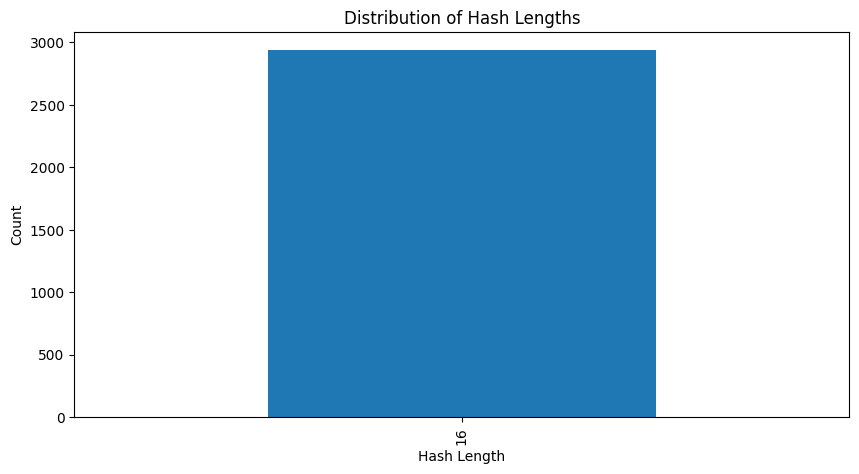

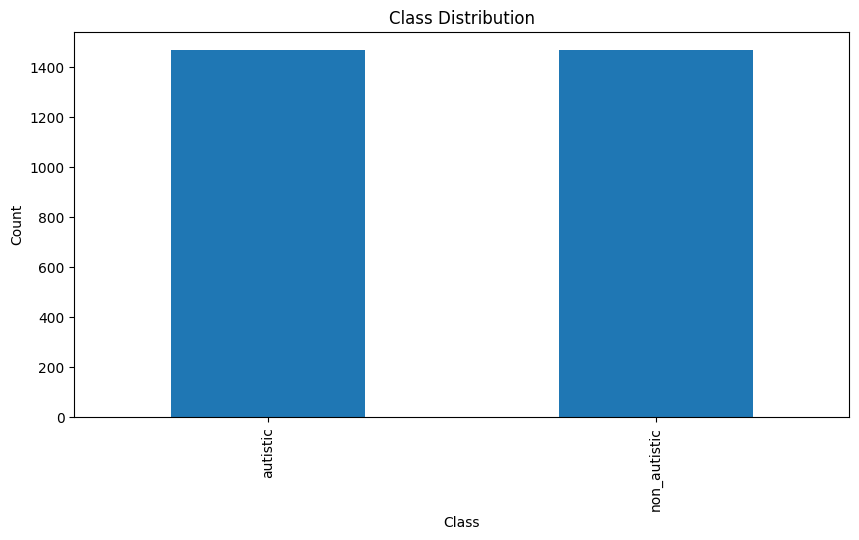

In [12]:
# Plot the distribution of hash lengths (should be consistent)
plt.figure(figsize=(10, 5))
df['hash_length'].value_counts().plot(kind='bar')
plt.title('Distribution of Hash Lengths')
plt.xlabel('Hash Length')
plt.ylabel('Count')
plt.show()

# Visualize the class distribution
plt.figure(figsize=(10, 5))
df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

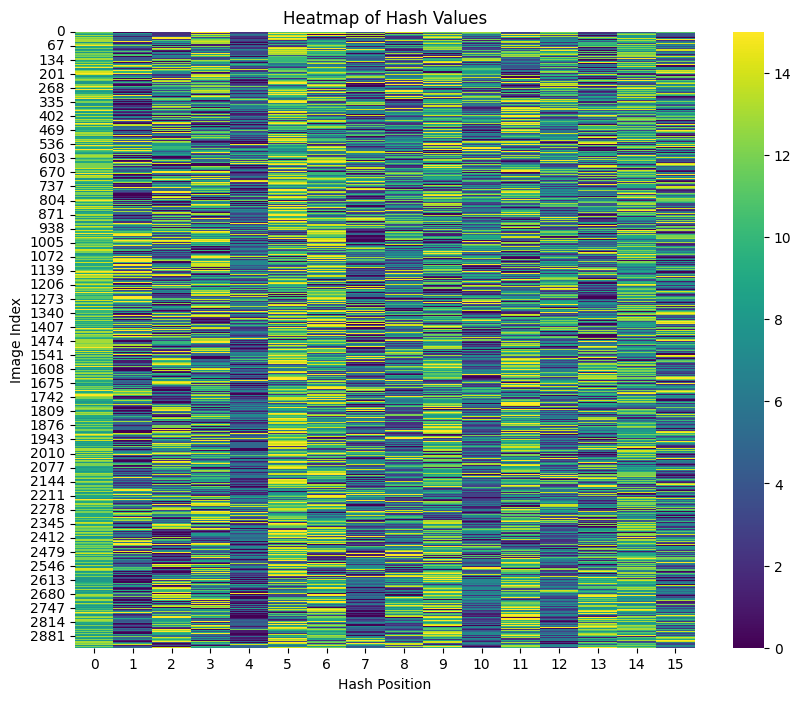

In [13]:
hash_matrix = df['hash'].apply(lambda x: np.array([int(c, 16) for c in x], dtype=np.uint8))
hash_matrix = np.vstack(hash_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(hash_matrix, cmap='viridis')
plt.title('Heatmap of Hash Values')
plt.xlabel('Hash Position')
plt.ylabel('Image Index')
plt.show()

## Hash Similarity Analysis

In [17]:
# Step 1: Convert hashes to binary
df['binary_hash'] = df['hash'].apply(lambda x: bin(int(x, 16))[2:].zfill(64))

# Display the DataFrame with binary hashes
df.head()


,filename,hash,label,mean,std,skewness,kurtosis,hash_length,binary_hash
0,0001.jpg,c06b2ff8b19086cf,autistic,139.447754,61.240496,-0.195112,-1.059572,16,1100000001101011001011111111100010110001100100...
1,0002.jpg,c03f6bb43990f4c3,autistic,127.053101,54.445597,-0.065493,-1.000039,16,1100000000111111011010111011010000111001100100...
2,0003.jpg,8d283c7d3394d4f4,autistic,147.401001,61.984623,-0.715674,-0.780351,16,1000110100101000001111000111110100110011100101...
3,0004.jpg,c02f2bb4ecd3c24b,autistic,135.558899,63.491497,-0.019400,-1.210997,16,1100000000101111001010111011010011101100110100...
4,0005.jpg,bf026c37633ae898,autistic,128.695129,66.594278,-0.037159,-0.853016,16,1011111100000010011011000011011101100011001110...


In [18]:
# Function to calculate Hamming distance between two binary strings
def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))


In [19]:
# Separate binary hashes by class
autistic_hashes = df[df['label'] == 'autistic']['binary_hash'].tolist()
non_autistic_hashes = df[df['label'] == 'non_autistic']['binary_hash'].tolist()

# Calculate Hamming distances for autistic class
autistic_distances = [hamming_distance(autistic_hashes[i], autistic_hashes[j]) 
                      for i in range(len(autistic_hashes)) 
                      for j in range(i+1, len(autistic_hashes))]

# Calculate Hamming distances for non-autistic class
non_autistic_distances = [hamming_distance(non_autistic_hashes[i], non_autistic_hashes[j]) 
                          for i in range(len(non_autistic_hashes)) 
                          for j in range(i+1, len(non_autistic_hashes))]

# Display some of the distances
print("Sample Autistic Hamming Distances:", autistic_distances[:5])
print("Sample Non-Autistic Hamming Distances:", non_autistic_distances[:5])


Sample Autistic Hamming Distances: [16, 24, 18, 38, 24]
Sample Non-Autistic Hamming Distances: [32, 28, 34, 28, 28]


In [20]:
# Calculate mean and standard deviation for Hamming distances
autistic_mean = np.mean(autistic_distances)
non_autistic_mean = np.mean(non_autistic_distances)
autistic_std = np.std(autistic_distances)
non_autistic_std = np.std(non_autistic_distances)

# Print the results
print(f"Autistic Class: Mean Hamming Distance = {autistic_mean}, Std = {autistic_std}")
print(f"Non-Autistic Class: Mean Hamming Distance = {non_autistic_mean}, Std = {non_autistic_std}")


Autistic Class: Mean Hamming Distance = 30.157180031538534, Std = 4.688141548449132
Non-Autistic Class: Mean Hamming Distance = 29.114029075631187, Std = 4.705927178929075


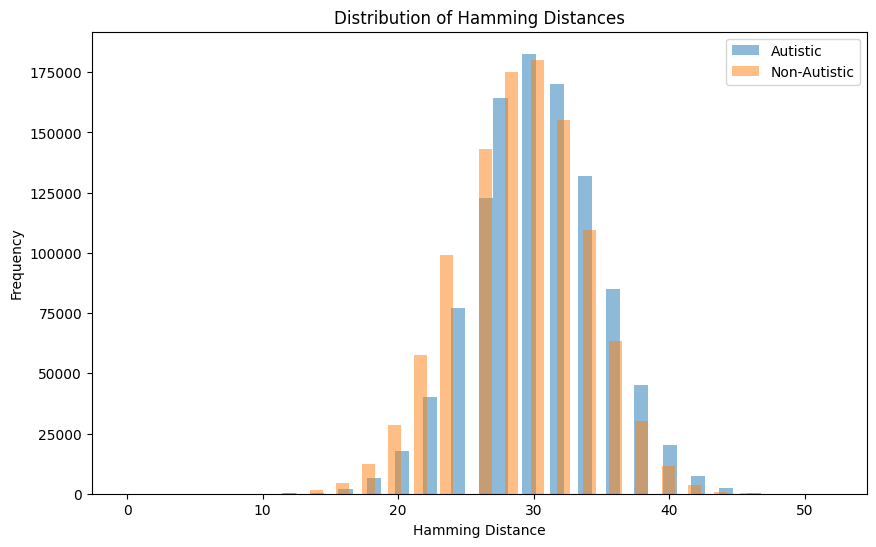

In [21]:
# Create a histogram to visualize the distribution of Hamming distances
plt.figure(figsize=(10, 6))
plt.hist(autistic_distances, bins=50, alpha=0.5, label='Autistic')
plt.hist(non_autistic_distances, bins=50, alpha=0.5, label='Non-Autistic')
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Hamming Distances')
plt.legend()
plt.show()


## Hexadecimal to integer conversion

In [23]:
df['hash_int'] = df['hash'].apply(lambda x: int(str(x), 16))

# Separate the hash values by class
autistic_hashes = df[df['label'] == 'autistic']['hash_int']
non_autistic_hashes = df[df['label'] == 'non_autistic']['hash_int']


## Statistical Testing on Hash values

### 1. T-Test

In [24]:
# Perform a two-sample t-test
t_stat, p_value = ttest_ind(autistic_hashes, non_autistic_hashes)

# Set significance level
alpha = 0.05

# Print results
print(f'Test Statistic: {t_stat}')
print(f'P-Value: {p_value}')
if p_value < alpha:
    print('\nAccepted hypothesis: \n\tThere is a significant difference in average hash values between the two classes.\n\tThe images in the two classes are perceptually distinct.')
else:
    print('Rejected hypothesis: \nThere is no significant difference in average hash values between the two classes.')


Test Statistic: 6.344654053347449
P-Value: 2.573418351189193e-10

Accepted hypothesis: 
	There is a significant difference in average hash values between the two classes.
	The images in the two classes are perceptually distinct.


### 2. Wilcoxon Rank-Sum Test

In [25]:
# Perform Wilcoxon rank-sum test (Mann-Whitney U)
statistic, pval = ranksums(autistic_hashes, non_autistic_hashes)

# Print the results
print(f"Wilcoxon Rank-Sum Statistic: {statistic}")
print(f"P-Value: {pval}")

# Interpret the results
if pval < alpha:
    print("\nAccepted hypothesis.:\n\tThere is a significant difference in the distributions of hash values between 'Autistic' and 'Non_Autistic' classes.\n\tThe images in the two classes are perceptually distinct.")
else:
    print("Rejected hypothesis.:\n\tThere is no significant difference in the distributions of hash values between 'Autistic' and 'Non_Autistic' classes.")


Wilcoxon Rank-Sum Statistic: 5.94889648042911
P-Value: 2.699562970618724e-09

Accepted hypothesis.:
	There is a significant difference in the distributions of hash values between 'Autistic' and 'Non_Autistic' classes.
	The images in the two classes are perceptually distinct.
